<a href="https://colab.research.google.com/github/lav162329/product-category-classifier/blob/main/notebooks/02_feature_engineering_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is dedicated to the application of advanced **Feature Engineering** techniques and the comparison of multiple Machine Learning algorithms. The primary goal is to create an optimal, robust model for automated product classification.

This notebook builds directly upon the data cleansing and exploratory insights gained from `01_data_exploration.ipynb`.

---

## 📥 Initialization and Data Loading

In [13]:
# Initialization and Data Loading

import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# Load the data and perform minimal essential cleaning (reproduction of initial steps)
url = "https://raw.githubusercontent.com/lav162329/product-category-classifier/main/data/products.csv"
df = pd.read_csv(url)

# Essential cleaning steps
df.columns = df.columns.str.strip()
df.dropna(subset=['Product Title', 'Category Label'], inplace=True)
df['Product Title'] = df['Product Title'].astype(str).str.lower()
df.reset_index(drop=True, inplace=True)

print(f"Data for modeling loaded and cleaned. Shape: {df.shape}")
print("\nReady to proceed with Feature Engineering.")

Data for modeling loaded and cleaned. Shape: (35096, 8)

Ready to proceed with Feature Engineering.


# Phase 1: Feature Engineering

## 2: Detailed Feature Engineering

This step involves creating specific numerical features (length, presence of units, etc.). Regular expression patterns are adapted using **non-capturing groups `(?:...)`** to suppress `UserWarning` and ensure compatibility across different Pandas versions. These features provide essential context to the model, significantly improving classification performance.

---

In [14]:
# Detailed Feature Engineering.

# Define the feature creation function
def create_engineered_features(df):

    titles = df['Product Title']

    # Structural Features
    df['title_length'] = titles.apply(len)
    df['word_count'] = titles.apply(lambda x: len(x.split()))

    # Binary Specification Markers (using non-capturing groups to prevent warnings)

    # 1. has_storage_unit: Capacity/Volume (GB, TB, L, KG)
    storage_pattern = r'(?:\d+)\s*(?:gb|tb|mb|l|kg|litre)\b'
    df['has_storage_unit'] = titles.str.contains(storage_pattern, regex=True).astype(int)

    # 2. has_dimension: Size (cm, inch, ")
    dimension_pattern = r'(?:\d+(?:\.\d+)?)\s*(?:cm|inch|")\b'
    df['has_dimension'] = titles.str.contains(dimension_pattern, regex=True).astype(int)

    # 3. has_digit: Presence of any number
    df['has_digit'] = titles.str.contains(r'\d+', regex=True).astype(int)

    # 4. is_tech_product: Common tech acronyms
    tech_pattern = r'\b(?:ssd|led|usb|hdmi|wifi|ghz|mp|core)\b'
    df['is_tech_product'] = titles.str.contains(tech_pattern, regex=True).astype(int)

    return df

# Apply and define feature columns
df = create_engineered_features(df)
FEATURE_COLS = ['title_length', 'word_count', 'has_storage_unit', 'has_dimension', 'has_digit', 'is_tech_product']

print("Engineered features created successfully.")
print(df[FEATURE_COLS].head())

Engineered features created successfully.
   title_length  word_count  has_storage_unit  has_dimension  has_digit  \
0            31           6                 1              0          1   
1            35           7                 1              0          1   
2            70          13                 1              0          1   
3            35           7                 1              0          1   
4            54          11                 1              0          1   

   is_tech_product  
0                0  
1                0  
2                0  
3                0  
4                0  


## 3: Standardization, Vectorization and Data Partitioning

Preparation of the final sparse matrix and storage of the transformers (Scaler, Vectorizer, Encoder).

In [15]:
# Standardization, Vectorization, and Data Split

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler # Dodajemo MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import joblib
import os
from sklearn.model_selection import train_test_split

# 1. Path Setup and Directory Creation
MODELS_PATH = '../models/'
os.makedirs(MODELS_PATH, exist_ok=True)

# Lista numeričkih karakteristika (preuzeta iz CELL 2)
FEATURE_COLS = ['title_length', 'word_count', 'has_storage_unit', 'has_dimension', 'has_digit', 'is_tech_product']

# 2. Standardization of Numerical Features
# Koristimo MinMaxScaler da osiguramo nenegativne vrednosti za ComplementNB
scaler = MinMaxScaler()
df[FEATURE_COLS] = scaler.fit_transform(df[FEATURE_COLS])
joblib.dump(scaler, os.path.join(MODELS_PATH, 'scaler.pkl'))
print("MinMaxScaler (used for compatibility) saved successfully.")

# 3. Encoding the Target Variable
le = LabelEncoder()
df['Category_Encoded'] = le.fit_transform(df['Category Label'])
y = df['Category_Encoded']
joblib.dump(le, os.path.join(MODELS_PATH, 'label_encoder.pkl'))
print("LabelEncoder saved successfully.")

# 4. Text Vectorization (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_text = tfidf_vectorizer.fit_transform(df['Product Title'])
joblib.dump(tfidf_vectorizer, os.path.join(MODELS_PATH, 'tfidf_vectorizer.pkl'))
print("TF-IDF Vectorizer saved successfully.")

# 5. Combining Features
X_numerical = df[FEATURE_COLS].values
X_final = hstack([X_text, X_numerical])

# 6. Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nCombined Feature Matrix Shape (X_final): {X_final.shape}")
print(f"Final Training Set Shape (X_train): {X_train.shape}")

MinMaxScaler (used for compatibility) saved successfully.
LabelEncoder saved successfully.
TF-IDF Vectorizer saved successfully.

Combined Feature Matrix Shape (X_final): (35096, 10006)
Final Training Set Shape (X_train): (28076, 10006)


## Phase 2: Modeling and Evaluation

4: Comparison of ML Algorithms (4 models)

---

In [16]:
# Model Comparison (Training and Macro F1 Evaluation)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define models
models = {
    "1. Logistic Regression": LogisticRegression(solver='saga', max_iter=500, random_state=42, n_jobs=-1, C=1.0),
    "2. Linear SVC": LinearSVC(random_state=42, C=0.5, max_iter=5000),
    "3. Complement Naive Bayes": ComplementNB(), # Sada radi zbog MinMaxScaler u CELL 3
    "4. Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20)
}

results = {}

print("--- Starting Model Training and Comparison ---")

for name, model in models.items():
    print(f"Training: {name}...")

    # Training
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0, output_dict=True)
    f1_macro = report['macro avg']['f1-score']

    results[name] = {"Accuracy": accuracy, "F1-Macro": f1_macro, "Model": model, "y_pred": y_pred}

    print(f"[{name}] Accuracy: {accuracy:.4f} | Macro F1-Score: {f1_macro:.4f}")

# Summary
summary_df = pd.DataFrame({
    'Model': [name for name in results.keys()],
    'Accuracy': [res['Accuracy'] for res in results.values()],
    'Macro F1-Score': [res['F1-Macro'] for res in results.values()]
}).sort_values(by='Macro F1-Score', ascending=False).reset_index(drop=True)

print("\n========== FINAL MODEL COMPARISON SUMMARY ==========")
print(summary_df.to_markdown(index=False))

best_model_name = summary_df.iloc[0]['Model']
best_model = results[best_model_name]['Model']
best_model_predictions = results[best_model_name]['y_pred']
print(f"\nOptimal Model Selected: **{best_model_name}**")

--- Starting Model Training and Comparison ---
Training: 1. Logistic Regression...
[1. Logistic Regression] Accuracy: 0.9544 | Macro F1-Score: 0.7382
Training: 2. Linear SVC...
[2. Linear SVC] Accuracy: 0.9577 | Macro F1-Score: 0.7405
Training: 3. Complement Naive Bayes...
[3. Complement Naive Bayes] Accuracy: 0.9474 | Macro F1-Score: 0.7318
Training: 4. Random Forest...
[4. Random Forest] Accuracy: 0.8732 | Macro F1-Score: 0.6761

========== FINAL MODEL COMPARISON SUMMARY ==========
| Model                     |   Accuracy |   Macro F1-Score |
|:--------------------------|-----------:|-----------------:|
| 2. Linear SVC             |   0.957692 |         0.740505 |
| 1. Logistic Regression    |   0.954416 |         0.738201 |
| 3. Complement Naive Bayes |   0.947436 |         0.731827 |
| 4. Random Forest          |   0.873219 |         0.676093 |

Optimal Model Selected: **2. Linear SVC**


## 5: Final Model Evaluation and Serialization

Visualization and saving of the best model in the models/ folder.


--- Detailed Classification Report for 2. Linear SVC ---
                  precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        17
            CPUs       0.98      1.00      0.99       749
 Digital Cameras       1.00      1.00      1.00       538
     Dishwashers       0.94      0.96      0.95       681
        Freezers       0.99      0.93      0.96       440
 Fridge Freezers       0.94      0.95      0.95      1094
         Fridges       0.88      0.91      0.89       687
      Microwaves       0.98      0.97      0.97       466
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.97      1.00      0.98       801
             TVs       0.99      0.99      0.99       708
Washing Machines       0.95      0.96      0.95       803
          fridge       0.00      0.00      0.00        25

        accuracy                           0.96      7020
       macro avg       0.74      0.74      0.74      7020
    weighted

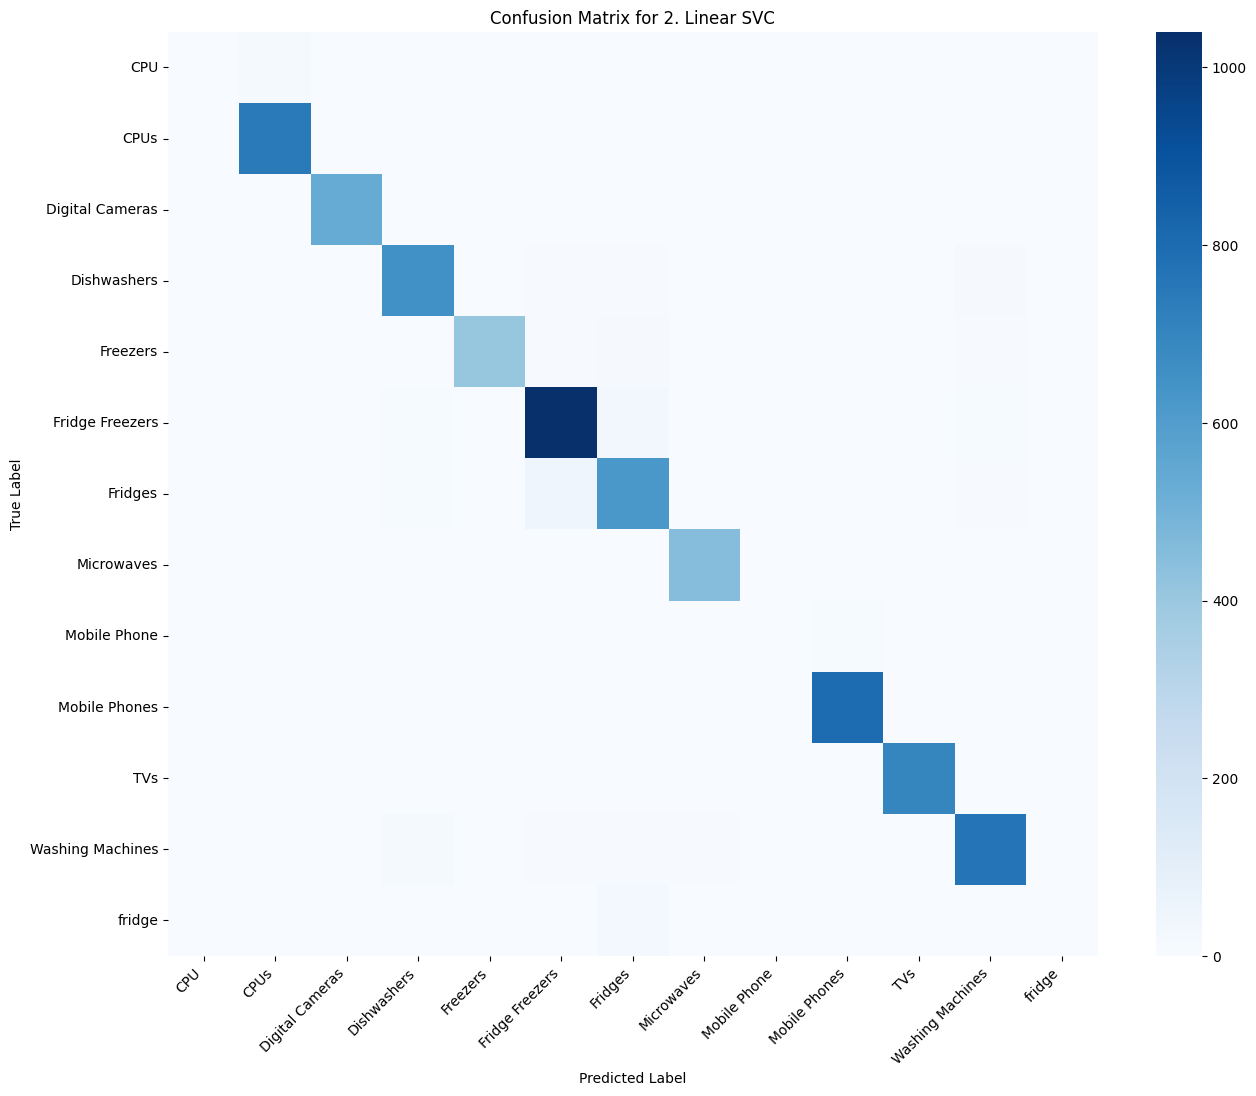


Final Model (2. Linear SVC) saved successfully to: ../models/product_classifier.pkl

--- NOTEBOOK ANALYSIS COMPLETE ---


In [17]:
# Final Evaluation and Model Saving

# 1. Detailed Classification Report
print(f"\n--- Detailed Classification Report for {best_model_name} ---")
print(classification_report(y_test, best_model_predictions, target_names=le.classes_, zero_division=0))

# 2. Confusion Matrix Visualization
cm = confusion_matrix(y_test, best_model_predictions)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_df, annot=False, cmap='Blues', fmt='d')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# 3. Model Serialization (Saving the final artifact)
# Save the model to the 'models/' directory
MODEL_PATH = '../models/product_classifier.pkl'
joblib.dump(best_model, MODEL_PATH)

print(f"\nFinal Model ({best_model_name}) saved successfully to: {MODEL_PATH}")
print("\n--- NOTEBOOK ANALYSIS COMPLETE ---")